In [1]:
import sys
print(sys.executable)


C:\Users\DELL\anaconda3\envs\reliability_py\python.exe


# fiabilipym — Monte Carlo Reliability Demo with Weibull Aging

This notebook demonstrates the **extended fiabilipym package** with full support for:

- Series system (3 components)
- Parallel system (3 components)
- Series–Parallel system (3 stages)
- Parallel–Series system (3 branches)
- Voting system (2-out-of-3)

All results are computed using **Monte Carlo simulation with Weibull aging**.

For each architecture we compute:
- **MTTF** (mean time to failure)
- **Reliability curves** \(R(t)\)

And we visualize:
- MTTF bar plot (per architecture)
- Reliability curves \(R(t)\)
- MTTF vs baseline \(\lambda\) (mean-matched sweep)

This notebook assumes the updated **fiabilipym** API:
- `Component.with_distribution(...)`
- `Weibull(beta, eta)`
- `System.monte_carlo(...)`
- `Voter.monte_carlo(...)`


## 0) Imports and setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fiabilipym import Component, System, Voter
from fiabilipym.distribution import Weibull, weibull_eta_from_lambda

# reproducibility
rng_seed = 42


## 1) Weibull aging parameters

We use:
- Weibull shape \(\beta > 1\) → aging / wear-out
- A baseline \(\lambda\) that is **mean-matched** to the Weibull scale

This keeps the traditional \(1/\lambda\) intuition while allowing non-exponential aging.


In [3]:
beta = 2.0          # Weibull shape (aging)
lam0 = 1e-4         # baseline lambda (mean-matched)
eta0 = weibull_eta_from_lambda(lam0, beta)

n_mc = 50_000       # Monte Carlo trials
t_max = 3.0 / lam0  # time horizon
T = np.linspace(0, t_max, 250)

print(f"beta = {beta}")
print(f"lambda = {lam0}")
print(f"eta (mean-matched) = {eta0:.6g}")


beta = 2.0
lambda = 0.0001
eta (mean-matched) = 11283.8


## 2) Helper: build Weibull-aging components

We attach Weibull lifetime distributions to each component via `with_distribution(...)`.

> If you implemented a different mechanism (e.g., `AgingComponent` subclass), adapt this function.


In [4]:
def aging_component(name: str, lam_baseline: float, beta: float, eta: float, age0: float = 0.0) -> Component:
    # lam_baseline is kept for backwards-compatibility / metadata; Monte Carlo uses the distribution.
    c = Component(name, lam_baseline)
    c.with_distribution(Weibull(beta=beta, eta=eta), age0=age0)
    return c


## 3) Build the 5 architectures (fiabilipym backbone)

We keep the exact style from classic fiabilipy/fiabilipym:
- Use `"E"` and `"S"` as entry/exit sentinel nodes
- Use intermediate string nodes like `"N1"`, `"N2"` where convenient


In [5]:
def build_series3(lam: float, beta: float, eta: float) -> System:
    c1 = aging_component("C1", lam, beta, eta)
    c2 = aging_component("C2", lam, beta, eta)
    c3 = aging_component("C3", lam, beta, eta)

    S = System()
    S["E"] = [c1]
    S[c1] = [c2]
    S[c2] = [c3]
    S[c3] = "S"
    return S

def build_parallel3(lam: float, beta: float, eta: float) -> System:
    c1 = aging_component("C1", lam, beta, eta)
    c2 = aging_component("C2", lam, beta, eta)
    c3 = aging_component("C3", lam, beta, eta)

    S = System()
    S["E"] = [c1, c2, c3]
    S[c1] = "S"
    S[c2] = "S"
    S[c3] = "S"
    return S

def build_series_parallel_3stages(lam: float, beta: float, eta: float) -> System:
    # (A1 || A2) -- (B1 || B2) -- (C1 || C2)
    A1 = aging_component("A1", lam, beta, eta)
    A2 = aging_component("A2", lam, beta, eta)
    B1 = aging_component("B1", lam, beta, eta)
    B2 = aging_component("B2", lam, beta, eta)
    C1 = aging_component("C1", lam, beta, eta)
    C2 = aging_component("C2", lam, beta, eta)

    S = System()
    S["E"] = [A1, A2]
    S[A1] = "N1"
    S[A2] = "N1"

    S["N1"] = [B1, B2]
    S[B1] = "N2"
    S[B2] = "N2"

    S["N2"] = [C1, C2]
    S[C1] = "S"
    S[C2] = "S"
    return S

def build_parallel_series_3branches(lam: float, beta: float, eta: float) -> System:
    # (A1--A2) || (B1--B2) || (C1--C2)
    A1 = aging_component("A1", lam, beta, eta)
    A2 = aging_component("A2", lam, beta, eta)
    B1 = aging_component("B1", lam, beta, eta)
    B2 = aging_component("B2", lam, beta, eta)
    C1 = aging_component("C1", lam, beta, eta)
    C2 = aging_component("C2", lam, beta, eta)

    S = System()
    S["E"] = [A1, B1, C1]

    S[A1] = [A2]
    S[A2] = "S"

    S[B1] = [B2]
    S[B2] = "S"

    S[C1] = [C2]
    S[C2] = "S"
    return S

def build_voter_2of3(lam: float, beta: float, eta: float):
    if Voter is None:
        raise ImportError("Voter is not available in this fiabilipym install.")

    # common signature: Voter(k, [components])
    base = aging_component("C", lam, beta, eta)

    # Voter expects a base component and M,N values
    return Voter(base, M=2, N=3)

ARCH_BUILDERS = {
    "Series (3)": build_series3,
    "Parallel (3)": build_parallel3,
    "Series–Parallel (3 stages)": build_series_parallel_3stages,
    "Parallel–Series (3 branches)": build_parallel_series_3branches,
    "Voter 2-out-of-3": build_voter_2of3,
}


## 4) Run Monte Carlo: MTTF + reliability curves

We use:
- `System.monte_carlo(n, grid_t, seed=..., return_samples=False)`
- `Voter.monte_carlo(...)`

and collect results for plotting.


In [6]:
objects = {}
mttf = {}
R_curves = {}
errors = {}

for name, builder in ARCH_BUILDERS.items():
    try:
        obj = builder(lam0, beta, eta0)
        objects[name] = obj

        # unified call: both System and Voter implement monte_carlo(...)
        out = obj.monte_carlo(n=n_mc, grid_t=T, seed=rng_seed, return_samples=False)
        # allow either (mttf, R) or dict-like
        if isinstance(out, tuple) and len(out) >= 2:
            mttf[name] = float(out[0])
            R_curves[name] = np.asarray(out[1], dtype=float)
        elif isinstance(out, dict):
            mttf[name] = float(out["mttf"])
            R_curves[name] = np.asarray(out["R"], dtype=float)
        else:
            raise TypeError(f"Unexpected monte_carlo() return type: {type(out)}")

    except Exception as e:
        errors[name] = str(e)

print("Computed architectures:", list(mttf.keys()))
if errors:
    print("\nSkipped architectures due to errors:")
    for k, v in errors.items():
        print(f"  - {k}: {v}")


Computed architectures: ['Series (3)', 'Parallel (3)', 'Series–Parallel (3 stages)', 'Parallel–Series (3 branches)', 'Voter 2-out-of-3']


## 5) MTTF summary table

In [7]:
try:
    import pandas as pd
except ImportError:
    pd = None

rows = [{"Architecture": k, "MTTF (MC)": v} for k, v in mttf.items()]
if pd is None:
    rows
else:
    df = pd.DataFrame(rows).sort_values("Architecture").reset_index(drop=True)
    df


## 6) Plot: MTTF bar chart

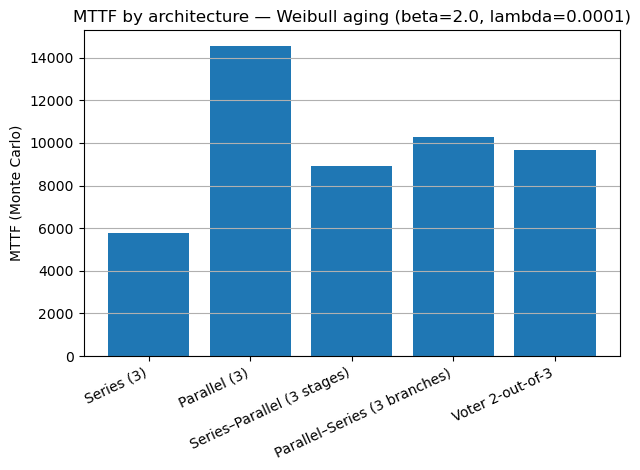

In [8]:
labels = list(mttf.keys())
vals = [mttf[k] for k in labels]

if not mttf:
    raise RuntimeError("No MTTF data computed. Check errors above.")

plt.figure()
plt.bar(labels, vals)
plt.ylabel("MTTF (Monte Carlo)")
plt.title(f"MTTF by architecture — Weibull aging (beta={beta}, lambda={lam0:g})")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 7) Plot: Reliability curves \(R(t)\)

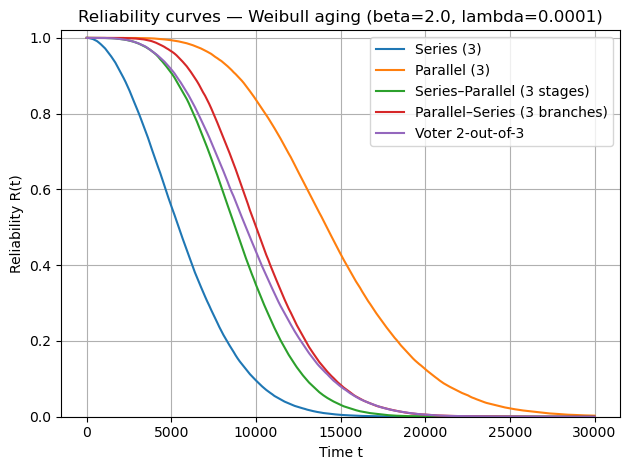

In [9]:
if not R_curves:
    raise RuntimeError("No R(t) curves computed. Check errors above.")

plt.figure()
for name, R in R_curves.items():
    plt.plot(T, R, label=name)

plt.xlabel("Time t")
plt.ylabel("Reliability R(t)")
plt.ylim(0, 1.02)
plt.title(f"Reliability curves — Weibull aging (beta={beta}, lambda={lam0:g})")
plt.grid(True)
if R_curves:
    plt.legend()
plt.tight_layout()
plt.show()


## 8) Optional: MTTF vs baseline \(\lambda\) sweep

We vary baseline \(\lambda\), mean-match Weibull \(\eta\), and recompute MTTF.

This illustrates how architecture interacts with overall component strength scale.


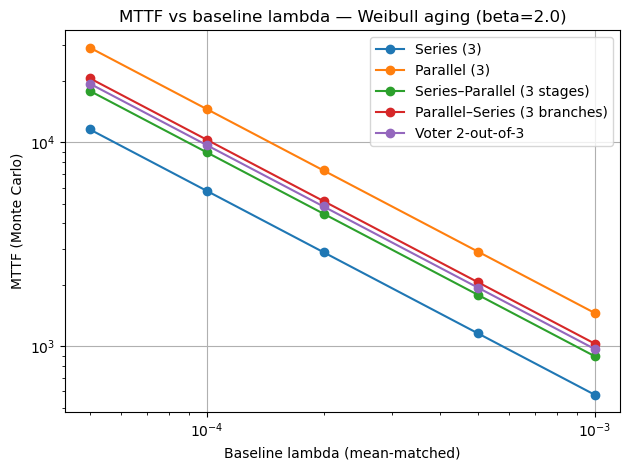

In [10]:
lams = np.array([5e-5, 1e-4, 2e-4, 5e-4, 1e-3], dtype=float)

plt.figure()
for name, builder in ARCH_BUILDERS.items():
    if name in errors:
        continue
    y = []
    for lam in lams:
        eta = weibull_eta_from_lambda(float(lam), beta)
        obj = builder(float(lam), beta, eta)
        out = obj.monte_carlo(n=20_000, grid_t=np.array([0.0]), seed=rng_seed, return_samples=False)
        m = float(out[0]) if isinstance(out, tuple) else float(out["mttf"])
        y.append(m)

    plt.plot(lams, y, marker="o", label=name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Baseline lambda (mean-matched)")
plt.ylabel("MTTF (Monte Carlo)")
plt.title(f"MTTF vs baseline lambda — Weibull aging (beta={beta})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Architecture Diagrams (Block-style)

This section appends block-style (RBD-like) architecture diagrams **after the Weibull/Monte Carlo results and plots**.
Use these figures for documentation and thesis integration.

# Block Diagrams (RBD-style) for Reliability Architectures

 Draws **block-style** (RBD-like) diagrams using **Matplotlib** .

Architectures included:
- Series (3)
- Parallel (3)
- Series–Parallel (3 stages, 2 in parallel per stage)
- Parallel–Series (3 branches, 2 in series per branch)
- 2-out-of-3 Voting


## 0) Imports + drawing utilities

We implement helpers to draw rectangular blocks and arrows.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

def draw_block(ax, xy, w, h, label, fontsize=10):
    """Draw a labeled rectangle (block) with black edges and white fill."""
    x, y = xy
    rect = Rectangle((x, y), w, h, linewidth=1.2, edgecolor="black", facecolor="white")
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha="center", va="center", fontsize=fontsize)
    return rect

def draw_arrow(ax, start, end):
    """Draw an arrow between two points."""
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=12,
                            linewidth=1.2, color="black")
    ax.add_patch(arrow)

def setup_ax(title, xlim, ylim):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal")
    ax.axis("off")
    return fig, ax

def right_mid(rect):
    x, y = rect.get_xy()
    w, h = rect.get_width(), rect.get_height()
    return (x + w, y + h/2)

def left_mid(rect):
    x, y = rect.get_xy()
    w, h = rect.get_width(), rect.get_height()
    return (x, y + h/2)


## 1) Series system (3 components)

Structure: `E -> C1 -> C2 -> C3 -> S`


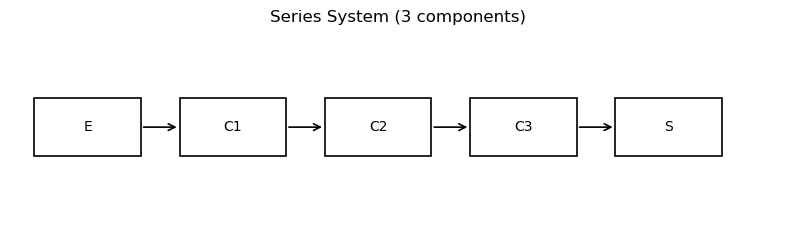

In [3]:
fig, ax = setup_ax("Series System (3 components)", xlim=(0, 16), ylim=(0, 4))

w, h = 2.2, 1.2
E  = draw_block(ax, (0.5, 1.4), w, h, "E")
C1 = draw_block(ax, (3.5, 1.4), w, h, "C1")
C2 = draw_block(ax, (6.5, 1.4), w, h, "C2")
C3 = draw_block(ax, (9.5, 1.4), w, h, "C3")
S  = draw_block(ax, (12.5, 1.4), w, h, "S")

draw_arrow(ax, right_mid(E), left_mid(C1))
draw_arrow(ax, right_mid(C1), left_mid(C2))
draw_arrow(ax, right_mid(C2), left_mid(C3))
draw_arrow(ax, right_mid(C3), left_mid(S))

plt.show()


## 2) Parallel system (3 components)

Structure: three components in parallel from `E` to `S`.


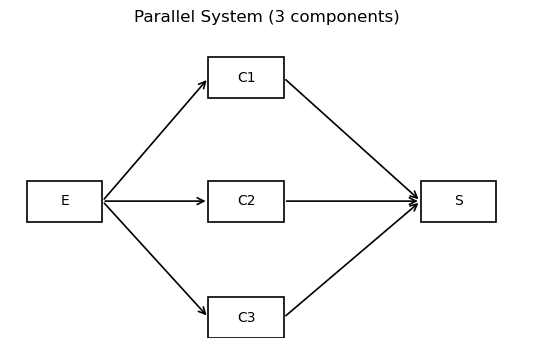

In [4]:
fig, ax = setup_ax("Parallel System (3 components)", xlim=(0, 15), ylim=(0, 9))

w, h = 2.2, 1.2
E = draw_block(ax, (0.5, 3.4), w, h, "E")
S = draw_block(ax, (12.0, 3.4), w, h, "S")

C1 = draw_block(ax, (5.8, 7.0), w, h, "C1")
C2 = draw_block(ax, (5.8, 3.4), w, h, "C2")
C3 = draw_block(ax, (5.8, 0), w, h, "C3")

draw_arrow(ax, right_mid(E), left_mid(C1))
draw_arrow(ax, right_mid(E), left_mid(C2))
draw_arrow(ax, right_mid(E), left_mid(C3))

draw_arrow(ax, right_mid(C1), left_mid(S))
draw_arrow(ax, right_mid(C2), left_mid(S))
draw_arrow(ax, right_mid(C3), left_mid(S))

plt.show()


## 3) Series–Parallel (3 stages, each stage = 2 in parallel)

Structure: `(A1 || A2) - (B1 || B2) - (C1 || C2)`


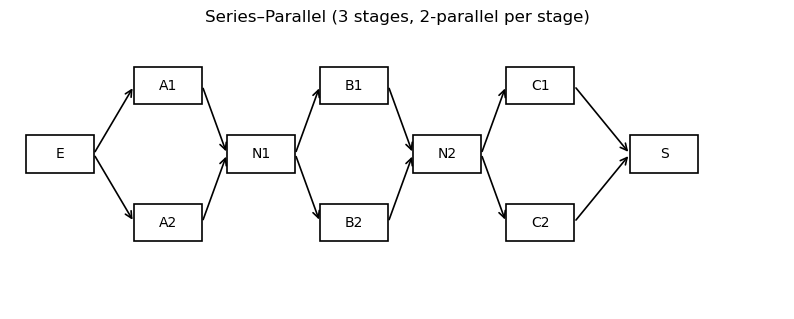

In [5]:
fig, ax = setup_ax("Series–Parallel (3 stages, 2-parallel per stage)", xlim=(0, 25), ylim=(0, 9))

w, h = 2.2, 1.2
E = draw_block(ax, (0.5, 4.4), w, h, "E")
S = draw_block(ax, (20.0, 4.4), w, h, "S")

A1 = draw_block(ax, (4.0, 6.6), w, h, "A1")
A2 = draw_block(ax, (4.0, 2.2), w, h, "A2")
N1 = draw_block(ax, (7.0, 4.4), w, h, "N1")

B1 = draw_block(ax, (10, 6.6), w, h, "B1")
B2 = draw_block(ax, (10, 2.2), w, h, "B2")
N2 = draw_block(ax, (13, 4.4), w, h, "N2")

C1 = draw_block(ax, (16, 6.6), w, h, "C1")
C2 = draw_block(ax, (16, 2.2), w, h, "C2")

ARROW_OFFSET = 0


def right_mid_out(block):
    x, y = right_mid(block)
    return (x + ARROW_OFFSET, y)

def left_mid_out(block):
    x, y = left_mid(block)
    return (x - ARROW_OFFSET, y)

draw_arrow(ax, right_mid_out(E), left_mid_out(A1))
draw_arrow(ax, right_mid_out(E), left_mid_out(A2))

draw_arrow(ax, right_mid_out(A1), left_mid_out(N1))
draw_arrow(ax, right_mid_out(A2), left_mid_out(N1))

draw_arrow(ax, right_mid_out(N1), left_mid_out(B1))
draw_arrow(ax, right_mid_out(N1), left_mid_out(B2))

draw_arrow(ax, right_mid_out(B1), left_mid_out(N2))
draw_arrow(ax, right_mid_out(B2), left_mid_out(N2))

draw_arrow(ax, right_mid_out(N2), left_mid_out(C1))
draw_arrow(ax, right_mid_out(N2), left_mid_out(C2))

draw_arrow(ax, right_mid_out(C1), left_mid_out(S))
draw_arrow(ax, right_mid_out(C2), left_mid_out(S))

plt.show()


## 4) Parallel–Series (3 branches, each branch = 2 in series)

Structure: `(A1-A2) || (B1-B2) || (C1-C2)`


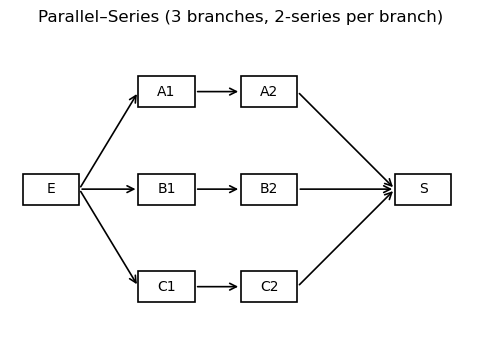

In [6]:
fig, ax = setup_ax("Parallel–Series (3 branches, 2-series per branch)", xlim=(0, 18), ylim=(0, 12))

w, h = 2.2, 1.2
E = draw_block(ax, (0.5, 5.2), w, h, "E")
S = draw_block(ax, (15.0, 5.2), w, h, "S")

A1 = draw_block(ax, (5.0, 9.0), w, h, "A1")
A2 = draw_block(ax, (9.0, 9.0), w, h, "A2")

B1 = draw_block(ax, (5.0, 5.2), w, h, "B1")
B2 = draw_block(ax, (9.0, 5.2), w, h, "B2")

C1 = draw_block(ax, (5.0, 1.4), w, h, "C1")
C2 = draw_block(ax, (9.0, 1.4), w, h, "C2")

draw_arrow(ax, right_mid(E), left_mid(A1))
draw_arrow(ax, right_mid(E), left_mid(B1))
draw_arrow(ax, right_mid(E), left_mid(C1))

draw_arrow(ax, right_mid(A1), left_mid(A2))
draw_arrow(ax, right_mid(B1), left_mid(B2))
draw_arrow(ax, right_mid(C1), left_mid(C2))

draw_arrow(ax, right_mid(A2), left_mid(S))
draw_arrow(ax, right_mid(B2), left_mid(S))
draw_arrow(ax, right_mid(C2), left_mid(S))

plt.show()


## 5) 2-out-of-3 Voting system

Blocks: `E -> (C1, C2, C3) -> Voter(2/3) -> S`


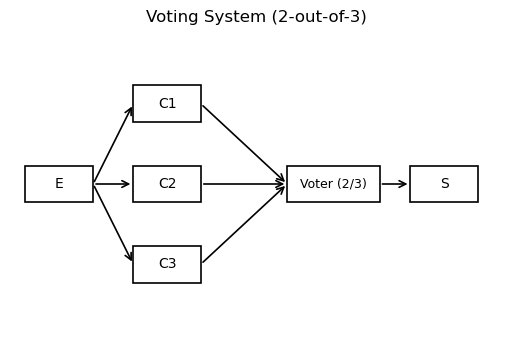

In [7]:
fig, ax = setup_ax("Voting System (2-out-of-3)", xlim=(0, 16), ylim=(0, 10))

w, h = 2.2, 1.2
E = draw_block(ax, (0.5, 4.4), w, h, "E")
V = draw_block(ax, (9.0, 4.4), w+0.8, h, "Voter (2/3)", fontsize=9)
S = draw_block(ax, (13.0, 4.4), w, h, "S")

C1 = draw_block(ax, (4.0, 7.0), w, h, "C1")
C2 = draw_block(ax, (4.0, 4.4), w, h, "C2")
C3 = draw_block(ax, (4.0, 1.8), w, h, "C3")

draw_arrow(ax, right_mid(E), left_mid(C1))
draw_arrow(ax, right_mid(E), left_mid(C2))
draw_arrow(ax, right_mid(E), left_mid(C3))

draw_arrow(ax, right_mid(C1), left_mid(V))
draw_arrow(ax, right_mid(C2), left_mid(V))
draw_arrow(ax, right_mid(C3), left_mid(V))

draw_arrow(ax, right_mid(V), left_mid(S))

plt.show()
